In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bagging, boosting, random forests

## Aggregation

1) Si p = 0.7 (ce qui est une prédiction faiblement au dessus de la chance à 0.5) et L = 1, 5, 10, 50, 100 quelle est la probabilité de prédiction correcte pour le modèle agrégé ? Pour L = 10 choisi, tracez les probabilités de la classification correct pour chaque nombre de classifieurs 1, 2, ..., 10. On pourra s’aider de l’implémentation de la distribution Binomiale dans scipy :

In [371]:
from scipy.stats import binom
from scipy.stats import bernoulli
import scipy.special
import math

p = 0.7
rv_agg = []

for L in range(1,100) :
    rv = binom(L, p)
    #r = binom.rvs(1, p, size=L)
    thr = math.ceil((L/2))
    rv_agg.append(1 - binom.cdf(thr, L, 0.7))

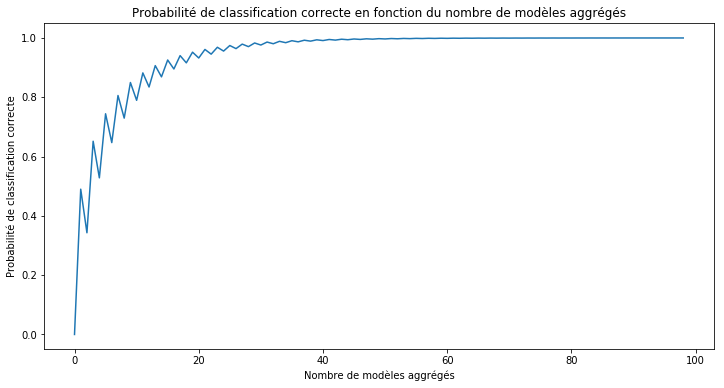

In [377]:
plt.figure(figsize=(12,6))
plt.plot(rv_agg)
plt.xlabel("Nombre de modèles aggrégés")
plt.ylabel('Probabilité de classification correcte')
plt.title("Probabilité de classification correcte en fonction du nombre de modèles aggrégés")
plt.show()

## Bagging

Le Bagging (acronyme venant de "Boostrap Aggregation") [Bre96] est une méthode classique pour combiner les modèles. Elle consiste à prendre une simple moyenne des prédictions, i.e., wl = 1/L. Afin de générer plusieurs estimateurs, on utilise plusieurs jeux de données générés aléatoirement en utilisant le bootstrap. Un échantillon bootstrap est un échantillon de n points d’apprentissage obtenus à partir de D par tirage aléatoire uniforme (avec remise).

2) Mettez en œuvre le Bagging avec des arbres de régression de profondeur 1 (en Anglais stumps), puis avec des arbres plus profonds, en partant du code ci-dessous. On pourra utiliser BaggingRegressor.

In [378]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [379]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

In [398]:
from sklearn.metrics import accuracy_score
clf = BaggingRegressor(DecisionTreeRegressor(max_depth = 1), n_estimators =10)
clf.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [399]:
pred = clf.predict(X_test)

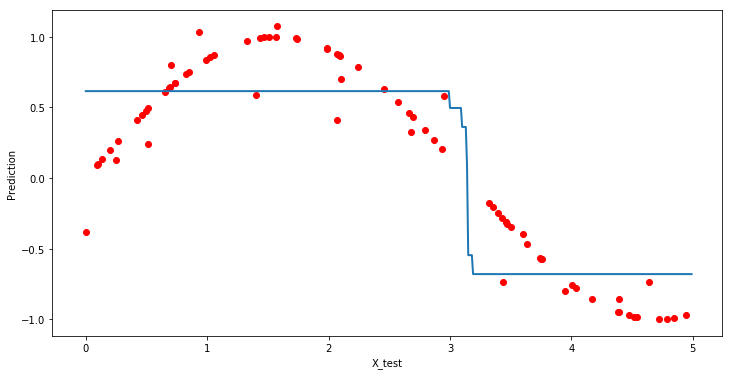

In [400]:
plt.figure(figsize=(12,6))
plt.plot(X_test, pred, linewidth=2)
plt.scatter(X,y, c="r")
plt.xlabel("X_test")
plt.ylabel("Prediction")
plt.show()

Pour une plus grande profondeur d'arbre :

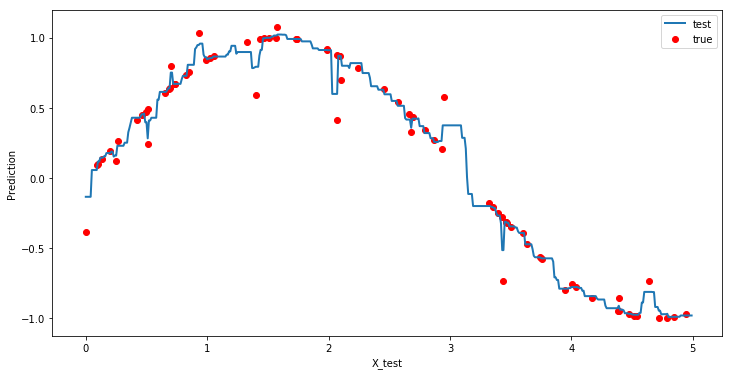

In [404]:
clf = BaggingRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators =10)

clf.fit(X, y)
pred = clf.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(X_test, pred, linewidth=2, label="test")
plt.scatter(X,y, c="r",label="true")
plt.xlabel("X_test")
plt.ylabel("Prediction")
plt.legend()
plt.show()

3) Illustrer graphiquement le rôle de L ainsi que de la profondeur des arbres (max_depth) en jouant sur ces deux paramètres.

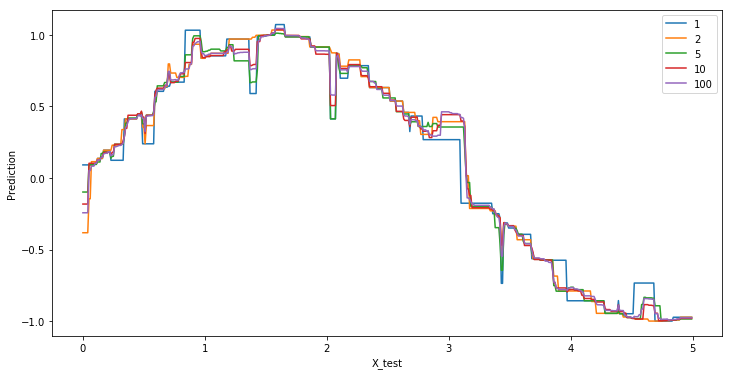

In [410]:
#Effect of the number of estimators
plt.figure(figsize=(12,6))

for L in [1, 2, 5, 10, 100] :
    clf = BaggingRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators = L)
    clf.fit(X,y)
    pred = clf.predict(X_test)
    plt.plot(X_test, pred, label=L)

plt.xlabel("X_test")
plt.ylabel("Prediction")
plt.legend()
plt.show()

Une augmentation du nombre d'estimateurs permet une distribution plus lisse, ce qui réduit la variance.

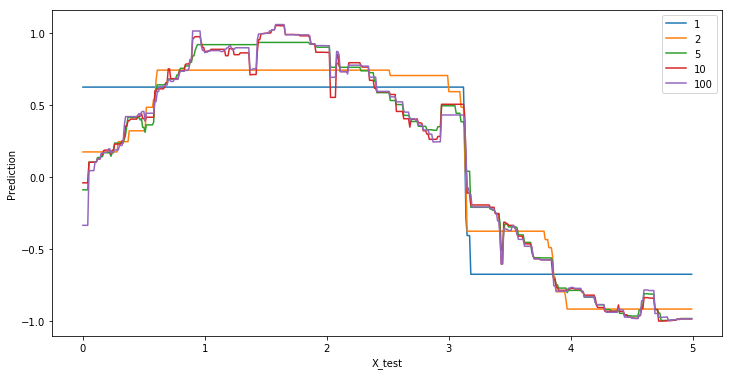

In [409]:
#Effect of the max depth
plt.figure(figsize=(12,6))

for j in [1, 2, 5, 10, 100] :
    clf = BaggingRegressor(DecisionTreeRegressor(max_depth = j), n_estimators = 10)
    clf.fit(X,y)
    pred = clf.predict(X_test)
    plt.plot(X_test, pred, label=j)

plt.xlabel("X_test")
plt.ylabel("Prediction")
plt.legend()
plt.show()

Une augmentation de la profondeur des arbres permet de réduire la variance, mais augmente également le biais.

4) A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le bagging réduit leur variance ?

**Réponse** : On remarque qu'appliquer un Bagging par dessus un Decision Tree Regressor permet de réduire la variance autour de la prédiction. Voici deux exemples, un avec le bagging, l'autre sans.

L'estimateur est moins variable dans le cas du bagging.

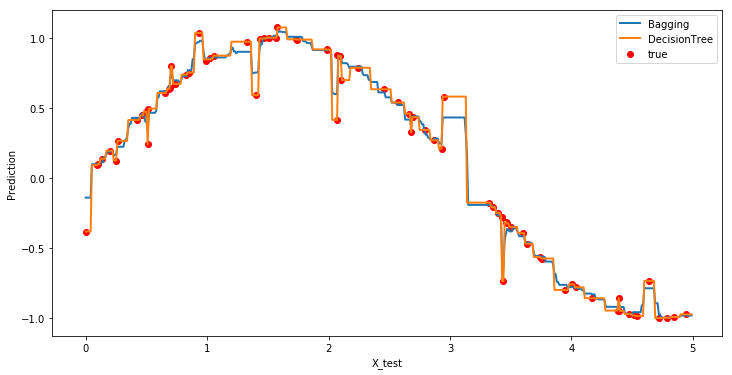

In [422]:
clf_bg = BaggingRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators =10)
clf_dt = DecisionTreeRegressor(max_depth = 10)

clf_bg.fit(X, y)
clf_dt.fit(X, y)

pred_bg = clf_bg.predict(X_test)
pred_dt = clf_dt.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(X_test, pred_bg, linewidth=2, label="Bagging")
plt.plot(X_test, pred_dt, linewidth=2, label="DecisionTree")

plt.scatter(X,y, c="r",label="true")
plt.xlabel("X_test")
plt.ylabel("Prediction")

plt.legend()
plt.show()

5) En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.

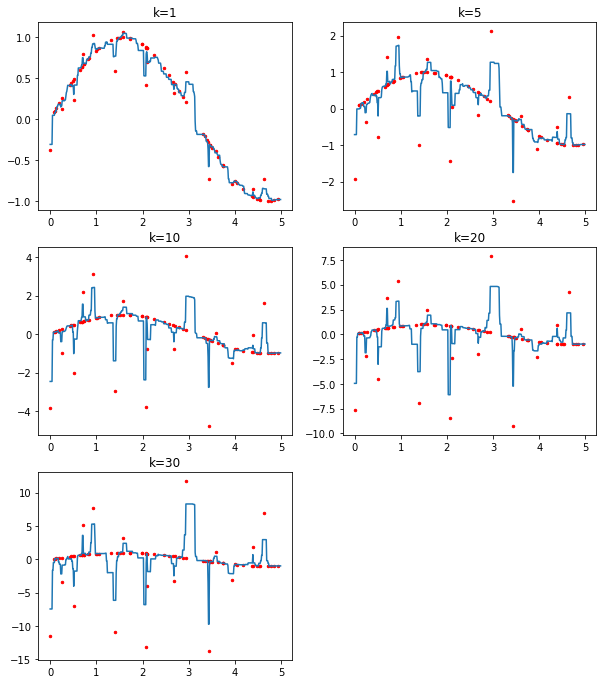

In [428]:
plt.figure(1,figsize=(10,20))

#k=1
plt.subplot(521)
plt.title("k=1")
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
clf = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf.fit(X, y)
pred = clf.predict(X_test)
plt.scatter(X,y, c="r",label="true", s=6)
plt.plot(X_test, pred)


#k=5
plt.subplot(522)
plt.title("k=5")
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 5 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
clf = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf.fit(X, y)
pred = clf.predict(X_test)
plt.scatter(X,y, c="r",label="true", s=6)
plt.plot(X_test, pred)

#k=30
plt.subplot(523)
plt.title("k=10")
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 10 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
clf = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf.fit(X, y)
pred = clf.predict(X_test)
plt.scatter(X,y, c="r",label="true", s=6)
plt.plot(X_test, pred)


#k=60
plt.subplot(524)
plt.title("k=20")
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 20 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
clf = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf.fit(X, y)
pred = clf.predict(X_test)
plt.scatter(X,y, c="r",label="true", s=6)
plt.plot(X_test, pred)

#k=n
plt.subplot(525)
plt.title("k=30")
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 30 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
clf = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf.fit(X, y)
pred = clf.predict(X_test)
plt.scatter(X,y, c="r",label="true", s=6)
plt.plot(X_test, pred)

plt.show()

Nous avons trop appris du bruit, ce qui influence trop nos prédictions.

6) Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.

In [429]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 5 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

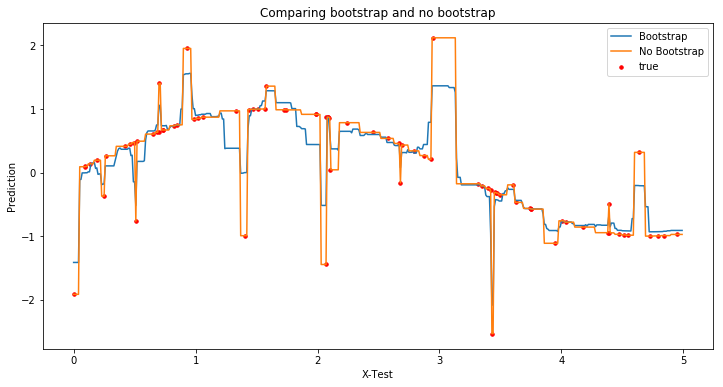

In [432]:
clf_bs = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20)
clf_nbs = BaggingRegressor(DecisionTreeRegressor(max_depth =20), n_estimators =20, bootstrap=False)

clf_bs.fit(X, y)
clf_nbs.fit(X, y)

pred_bs = clf_bs.predict(X_test)
pred_nbs = clf_nbs.predict(X_test)

plt.figure(figsize=(12,6))
plt.scatter(X,y, c="r",label="true", s=12)

plt.plot(X_test, pred_bs, label = "Bootstrap")
plt.plot(X_test, pred_nbs, label = "No Bootstrap")

plt.xlabel('X-Test')
plt.ylabel('Prediction')

plt.title("Comparing bootstrap and no bootstrap")
plt.legend()
plt.show()

Quand il n'y a pas de bootstrap, le biais est réduit mais la variance est bien plus importante.

## Random Forests

Les forêts aléatoires (en : Random Forests) [Bre01], combinent l’idée du Bagging, l’échantillonnage par bootstrap et moyennage, avec une sélection aléatoire des variables à chaque nœud de la construction de l’arbre. Dans le cas de la classification, l’agrégation se fait par vote majoritaire.

7) Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes, iris et digits. Comparez ces performances avec celles d’un SVM linéaire. On pourra utiliser :

In [433]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Boston dataset

#### Random Forest

In [434]:
from sklearn.datasets import load_boston
from sklearn.metrics import accuracy_score

In [435]:
dataset = load_boston()
X = dataset['data']
y = dataset['target']

In [436]:
reg = RandomForestRegressor()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.6281698087256339

#### SVR

In [437]:
from sklearn.svm import SVR
reg = SVR()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

-0.4998841406097491

### Diabetes

#### Random Forest

In [438]:
from sklearn.datasets import load_diabetes

In [439]:
dataset = load_diabetes()
X = dataset['data']
y = dataset['target']

In [440]:
reg = RandomForestRegressor()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.37052376453122254

#### SVR

In [441]:
from sklearn.svm import SVR
reg = SVR()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

-0.048713720961409454

### Iris

#### Random Forest

In [442]:
from sklearn.datasets import load_iris

In [443]:
dataset = load_iris()
X = dataset['data']
y = dataset['target']

In [444]:
reg = RandomForestClassifier()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.9668367346938777

#### SVM

In [445]:
from sklearn import svm
reg = svm.SVC()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.9600340136054423

### Digits

#### Random Forest

In [446]:
from sklearn.datasets import load_digits

In [447]:
dataset = load_digits()
X = dataset['data']
y = dataset['target']

In [448]:
reg = RandomForestClassifier()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.898070359638095

#### SVM

In [449]:
from sklearn import svm
reg = svm.SVC()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.4411009490588834

8) En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité de prédiction des classes.

In [450]:
from sklearn import preprocessing

# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)

In [357]:
reg = RandomForestClassifier()
scores = cross_val_score(reg, X, y, cv=7)
scores.mean()

0.7482993197278912

In [358]:
from sklearn.model_selection import cross_val_predict
proba = cross_val_predict(reg, X, y, cv=7, method='predict_proba')

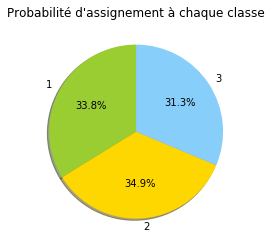

In [451]:
sizes = [proba[:,0].mean(), proba[:,1].mean(), proba[:,2].mean()]
colors = ['yellowgreen', 'gold', 'lightskyblue']
plt.pie(sizes, labels=[1,2,3], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Probabilité d'assignement à chaque classe")
plt.show()

9) Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions pures (obtenus avec DecisionTreeClassifier), sur le dataset digits. On fera varier le paramètre max_depth entre 1 et 15. Mettre en évidence le fait que les Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds.

In [461]:
dataset = load_digits()
X = dataset['data']
y = dataset['target']

In [462]:
from sklearn.tree import DecisionTreeClassifier

reg_rf = RandomForestClassifier()
reg_dt = DecisionTreeClassifier()

scores_rf = cross_val_score(reg_rf, X, y, cv=6)
scores_dt = cross_val_score(reg_dt, X, y, cv=6)

print("Le score pour le Random Forest est : " + str(scores_rf.mean()))
print("Le score pour le Decision Tree est : " + str(scores_dt.mean()))

Le score pour le Random Forest est : 0.9093003209518175
Le score pour le Decision Tree est : 0.791390735956013


In [463]:
rf_score = []
dt_score = []

for depth in range(1,16) :
    reg_rf = RandomForestClassifier(max_depth = depth)
    reg_dt = DecisionTreeClassifier(max_depth = depth)

    scores_rf = cross_val_score(reg_rf, X, y, cv=6)
    scores_dt = cross_val_score(reg_dt, X, y, cv=6)

    rf_score.append(scores_rf.mean())
    dt_score.append(scores_dt.mean())
    

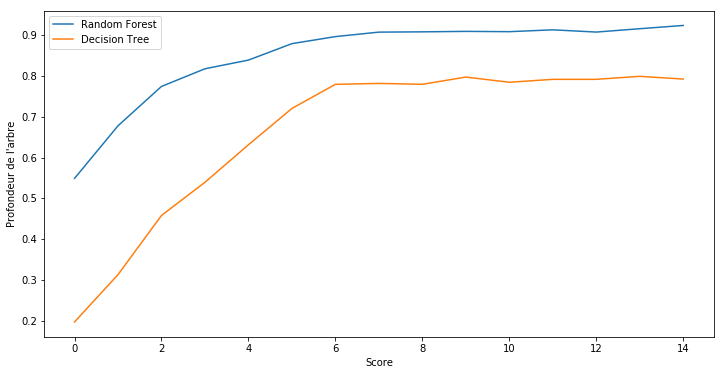

In [464]:
plt.figure(figsize=(12,6))

plt.plot(rf_score, label="Random Forest")
plt.plot(dt_score, label="Decision Tree")
plt.xlabel("Score")
plt.ylabel("Profondeur de l'arbre")
plt.legend()

plt.show()

Si on ajoute du bruit aux données :

In [484]:
dataset = load_digits()
X = dataset['data'] 
y = dataset['target'] + 5 * int(np.random.normal(0,100, 1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [481]:
rf_score = []
dt_score = []

for depth in range(1,16) :
    reg_rf = RandomForestClassifier(max_depth = depth)
    reg_dt = DecisionTreeClassifier(max_depth = depth)

    scores_rf = cross_val_score(reg_rf, X, y, cv=6)
    scores_dt = cross_val_score(reg_dt, X, y, cv=6)

    rf_score.append(scores_rf.mean())
    dt_score.append(scores_dt.mean())
    

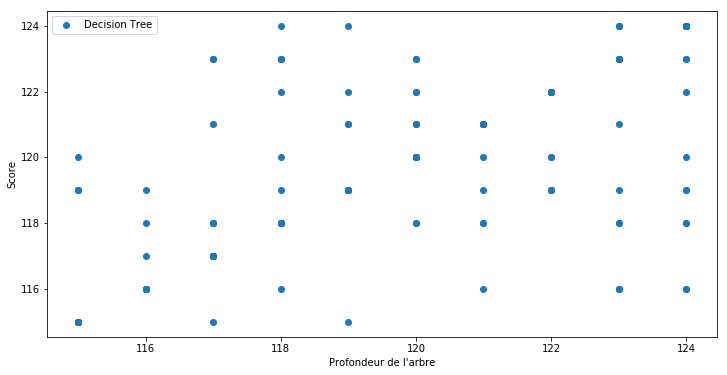

In [486]:
reg_dt = DecisionTreeClassifier(max_depth = 20)
reg_dt.fit(X_train, y_train)
pred_dt = reg_dt.predict(X_test)

plt.figure(figsize=(12,6))

#plt.plot(rf_score, label="Random Forest")
plt.scatter(y_test, pred_dt, label="Decision Tree")
plt.ylabel("Score")
plt.xlabel("Profondeur de l'arbre")
plt.legend()

plt.show()

## Boosting

D’un point de vue historique, l’un des premiers algorithmes de Boosting à rencontrer un réel suc- cès s’appelle “l’AdaBoost.M1” et a été proposé par Freund et Schapire [FS97]. Quelques informations supplémentaires sont disponibles dans [Fri01, FHRT00], [HTF09, Chapitre 10].

## Boosting

14) Mettre en œuvre AdaBoost avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données digits. On calculera notamment la précision obtenue par 6-fold cross-validation. On pourra utiliser par exemple

In [487]:
from sklearn.ensemble import AdaBoostClassifier
dataset = load_digits()
X = dataset['data']
y = dataset['target']

In [488]:
score = []
for depth in [1,2,10] : 
    reg_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth))
    scores_ada = cross_val_score(reg_ada, X, y, cv=6)
    score.append(scores_ada.mean())

In [493]:
score

[0.2636257855582272, 0.5902852679072207, 0.9604789928344561]

15) Appliquer AdaBoost sur les données digits découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

In [351]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [352]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

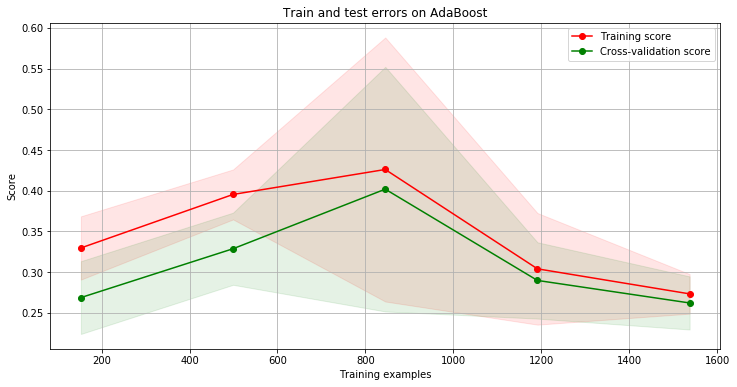

In [501]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

reg_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

plot_learning_curve(reg_ada, "Train and test errors on AdaBoost",X, y, cv=7, n_jobs=4)
plt.show()

Si la profondeur des arbres de classification est grande :

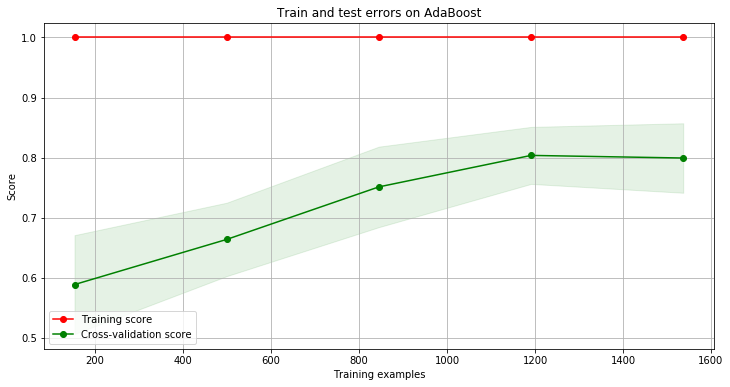

In [498]:
reg_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=30))

plot_learning_curve(reg_ada, "Train and test errors on AdaBoost",X, y, cv=7, n_jobs=4)
plt.show()

L'erreur d'entrainement devient nulle. On overfit, et notre arbre descend trop loin.

17) Implémenter vous-même l’algorithme AdaBoost.

In [502]:
def get_error_rate(pred, Y) :
    return sum(pred != Y)/float(len(Y))

In [506]:
def generic_clf(X_train, Y_train, X_test, Y_test, clf) :
    clf.fit(Y_train, Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

In [507]:
def adaboost_clf(X_train, Y_train, X_test, Y_test, M, clf) :
    n_train, n_test = len(X_train), len(X_test)
    #Initialoze weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M) :
        clf.fit(X_train, Y_train, sample_weight=w)
        #Prediction
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        #Indicator functions
        miss = [int(x) for x in (pred_train_i != Y_train)]
        miss2 = [x if x==1 else -1 for x in miss]
        #Error
        err_m = np.dot(w,miss)/sum(w)
        #Alpha 
        alpha_m = 0.5 * np.log((1-err_m)/float(err_m))
        #New weight
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        #Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)
        

In [511]:
adaboost_clf(X_train, y_train, X_test, y_test, 100, DecisionTreeClassifier(max_depth=1))

(1.0, 1.0)